In [52]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as fn

from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans

import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
spark = SparkSession.builder.appName('Telecom explore').getOrCreate()

In [3]:
# read data from csv file
telecom = spark.read.csv('/home/namntse05438/datasets/telecom/sms-call-internet-mi-2013-11-07.csv', header=True)

In [4]:
telecom.show(5)

+-------------------+------+-----------+------+------+------+-------+--------+
|           datetime|CellID|countrycode| smsin|smsout|callin|callout|internet|
+-------------------+------+-----------+------+------+------+-------+--------+
|2013-11-07 00:00:00|     1|          0|0.2463|  null|  null|   null|    null|
|2013-11-07 00:00:00|     1|         39|1.4627| 1.661|0.2999| 0.1644| 55.8591|
|2013-11-07 00:00:00|     2|          0|0.2467|  null|  null|   null|    null|
|2013-11-07 00:00:00|     2|         39|1.4768|1.6736|0.3033| 0.1648| 56.0243|
|2013-11-07 00:00:00|     3|          0|0.2471|  null|  null|   null|    null|
+-------------------+------+-----------+------+------+------+-------+--------+
only showing top 5 rows



In [5]:
# 1. Cleaning data:
## a. Drop duplicate:

In [6]:
# number of duplicate row (every row is distinct)
print('row count:', telecom.count())
print('row count distinct:', telecom.distinct().count())

row count: 2407384
row count distinct: 2407384


In [7]:
# drop duplicate
telecom = telecom.dropDuplicates()

In [8]:
# get number of unique id
id = telecom.select('CellID').distinct().count()
id

10000

In [9]:
# cast numeric value to numeric type
numeric_cols = ["CellID","countrycode", "smsin","smsout","callin","callout","internet"]
for c in numeric_cols:
    telecom = telecom.withColumn(c, telecom[c].cast('double'))

In [10]:
# shema
telecom.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- CellID: double (nullable = true)
 |-- countrycode: double (nullable = true)
 |-- smsin: double (nullable = true)
 |-- smsout: double (nullable = true)
 |-- callin: double (nullable = true)
 |-- callout: double (nullable = true)
 |-- internet: double (nullable = true)



In [11]:
# 2. Missing observation:

In [12]:
# explore ratio of missing value in each column
missing_ratio = telecom.agg(*[(1-fn.count(c)/fn.count('*')).alias(c+"_missing") for c in telecom.columns])
missing_ratio.show()

+----------------+--------------+-------------------+------------------+-----------------+------------------+------------------+------------------+
|datetime_missing|CellID_missing|countrycode_missing|     smsin_missing|   smsout_missing|    callin_missing|   callout_missing|  internet_missing|
+----------------+--------------+-------------------+------------------+-----------------+------------------+------------------+------------------+
|             0.0|           0.0|                0.0|0.6200589519578098|0.775083659274964|0.7176433007779399|0.5887851709573546|0.5397020167949941|
+----------------+--------------+-------------------+------------------+-----------------+------------------+------------------+------------------+



In [13]:
# count number of call-in, call-out, sms-in, sms-out, internet using times 
cols = ["smsin","smsout","callin","callout","internet"]
cellid_group = telecom.groupBy('CellID')

# telecom data create new feature corresponding to each user
telecom_data = cellid_group.agg(
    *[fn.count(c).alias('n_'+c) for c in cols]
    + [fn.avg(c).alias('avg_'+c) for c in cols]
)

In [14]:
telecom_data.show()

+------+-------+--------+--------+---------+----------+------------------+-------------------+------------------+------------------+------------------+
|CellID|n_smsin|n_smsout|n_callin|n_callout|n_internet|         avg_smsin|         avg_smsout|        avg_callin|       avg_callout|      avg_internet|
+------+-------+--------+--------+---------+----------+------------------+-------------------+------------------+------------------+------------------+
|3597.0|     98|      59|      83|      144|       109| 4.035041836734691| 3.2667050847457624| 3.444984337349398|1.7416124999999993| 37.95543486238531|
|2815.0|    110|      67|      79|      102|       148|2.2596536363636366|  2.042950746268657| 2.054721518987342|1.7507500000000005| 22.31372905405405|
|5858.0|    224|     146|     182|      207|       197| 31.90848482142857| 22.879879452054787| 25.80458626373626| 21.67320289855073| 530.3432979695433|
| 496.0|    126|      59|      80|       99|       162|0.8149182539682539|  0.6171084745

In [15]:
cols = telecom_data.columns
cols.remove('CellID')

In [16]:
# assemble feature vector
vec_assemble = VectorAssembler(inputCols=cols, outputCol='features')

# pipe_data = vec_assmble.transform(telecom_data)

In [17]:
# drop rows containing not a number value from telecom_data
telecom_data_dropna = telecom_data.dropna()

In [18]:
# pipeline
pipeline = Pipeline(stages=[vec_assemble])

pipe_model = pipeline.fit(telecom_data_dropna)

pipe_data = pipe_model.transform(telecom_data_dropna)

In [20]:
# define Kmean clustering model, choosing the best K
cost = []
ks = []
models = []

def k_and_cost(cost, ks, models, _min, _max, _step):
    for k in range(_min, _max, _step):
        kmeans = KMeans().setK(k).setSeed(1)
        model = kmeans.fit(pipe_data.sample(False, 0.01,seed=42))
        cost.append(model.computeCost(pipe_data))
        ks.append(k)
        models.append(model)

In [47]:
k_and_cost(cost, ks,models, 10,13,1)

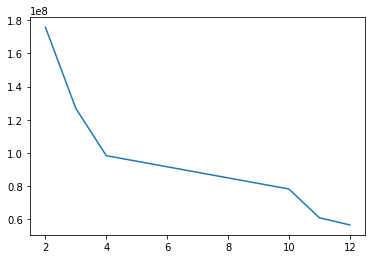

In [49]:
# plot cost corresponding to each value of k
plt.plot(ks, cost)
plt.show()

In [21]:
# choose the best shit
# idx = np.argmin(np.array(cost))
# best_model = models[idx]

kmeans = KMeans().setK(10).setSeed(1)
best_model = kmeans.fit(pipe_data)

In [22]:
pred = best_model.transform(pipe_data)

In [23]:
pred.show()

+------+-------+--------+--------+---------+----------+------------------+-------------------+------------------+------------------+------------------+--------------------+----------+
|CellID|n_smsin|n_smsout|n_callin|n_callout|n_internet|         avg_smsin|         avg_smsout|        avg_callin|       avg_callout|      avg_internet|            features|prediction|
+------+-------+--------+--------+---------+----------+------------------+-------------------+------------------+------------------+------------------+--------------------+----------+
|3597.0|     98|      59|      83|      144|       109| 4.035041836734691| 3.2667050847457624| 3.444984337349398|1.7416124999999993| 37.95543486238531|[98.0,59.0,83.0,1...|         8|
|2815.0|    110|      67|      79|      102|       148|2.2596536363636366|  2.042950746268657| 2.054721518987342|1.7507500000000005| 22.31372905405405|[110.0,67.0,79.0,...|         8|
|5858.0|    224|     146|     182|      207|       197| 31.90848482142857| 22.87

In [26]:
group1 = pred.filter(fn.col('prediction')==1)

In [59]:
group2 = pred.filter(fn.col('prediction')==2)

2 3


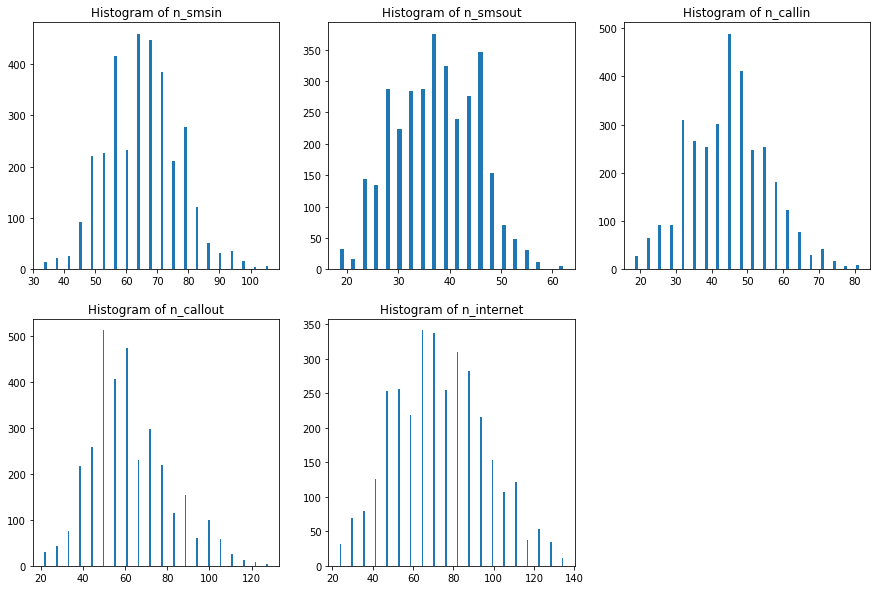

In [58]:
def visualize(df, col_names):
    n_subplot = len(col_names)
    n_cols = 3
    n_rows = math.ceil(n_subplot*1.0/n_cols)
    plt.figure(figsize=(5*n_cols, 5*n_rows))
    print(n_rows, n_cols)
    for i, col in enumerate(col_names):
        sub = plt.subplot(n_rows,n_cols,i+1)
        hist = df.select(col).rdd.flatMap(lambda row: row).histogram(20)
        sub.bar(hist[0][:-1], hist[1])
        plt.title('Histogram of '+col)
    

3 3


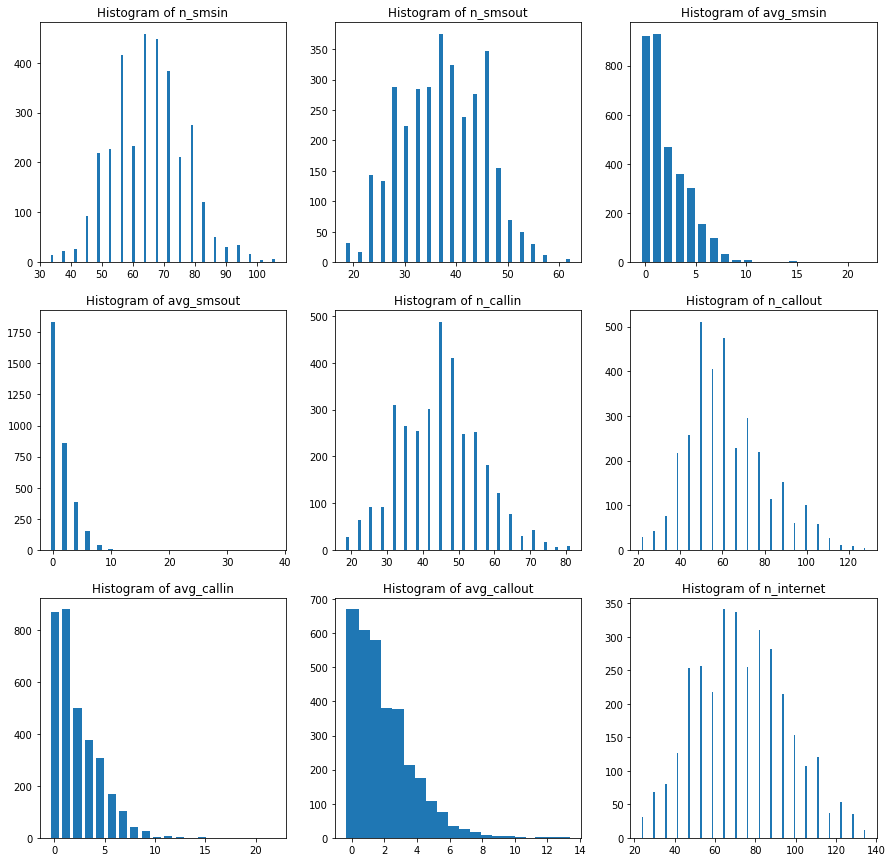

In [69]:
visualize(group1,['n_smsin', 'n_smsout','avg_smsin','avg_smsout', 'n_callin', 'n_callout','avg_callin','avg_callout', 'n_internet'])

3 3


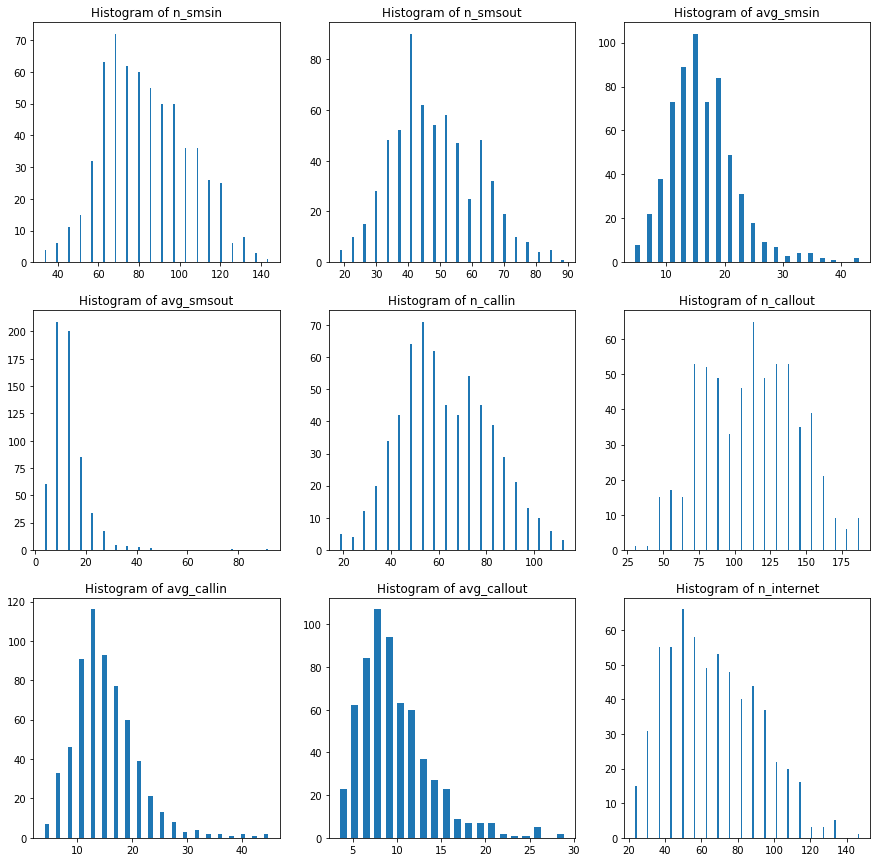

In [70]:
visualize(group2,['n_smsin', 'n_smsout','avg_smsin','avg_smsout', 'n_callin', 'n_callout','avg_callin','avg_callout', 'n_internet'])

2 3


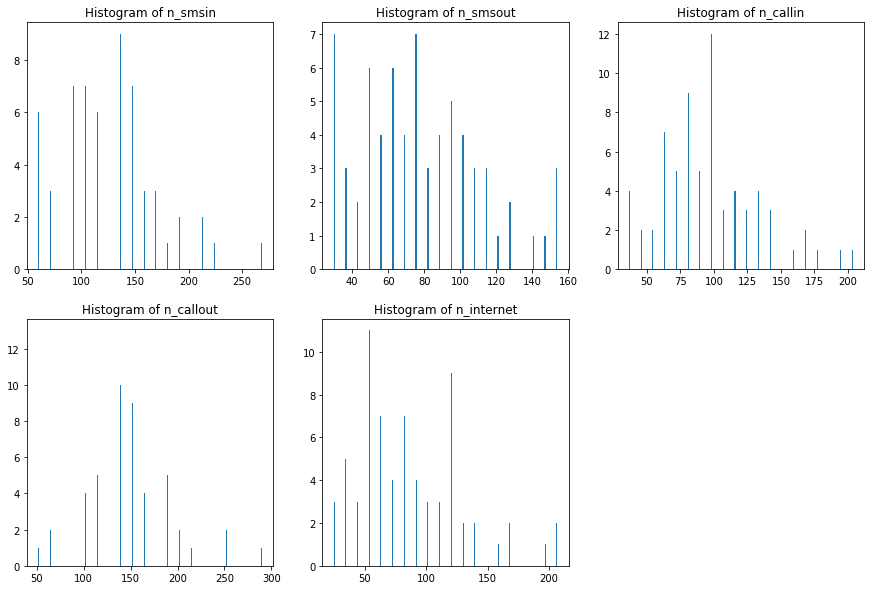

In [62]:
group3 = pred.filter(fn.col('prediction')==3)
visualize(group3,['n_smsin', 'n_smsout', 'n_callin', 'n_callout', 'n_internet'])

2 3


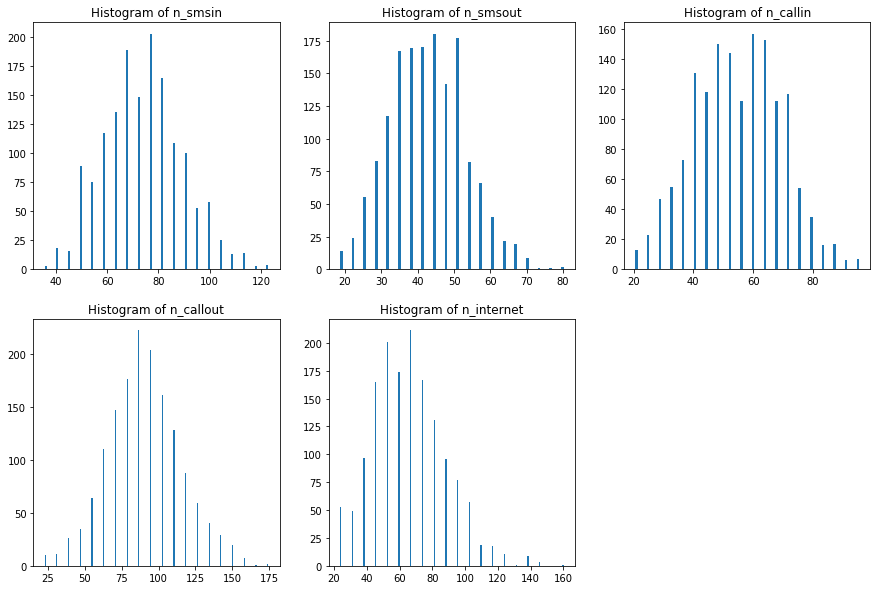

In [64]:
group4 = pred.filter(fn.col('prediction')==4)
visualize(group4,['n_smsin', 'n_smsout', 'n_callin', 'n_callout', 'n_internet'])

2 3


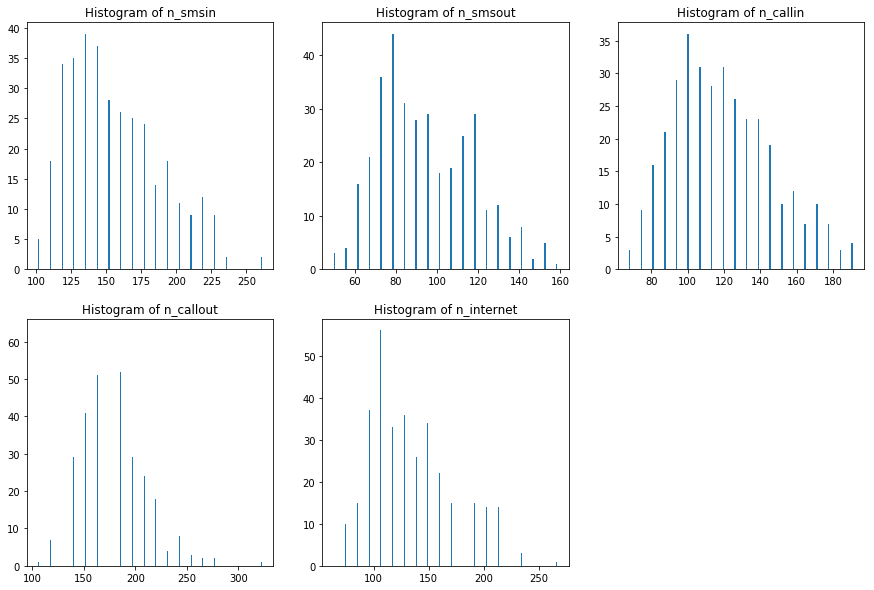

In [65]:
group5 = pred.filter(fn.col('prediction')==5)
visualize(group5,['n_smsin', 'n_smsout', 'n_callin', 'n_callout', 'n_internet'])

2 3


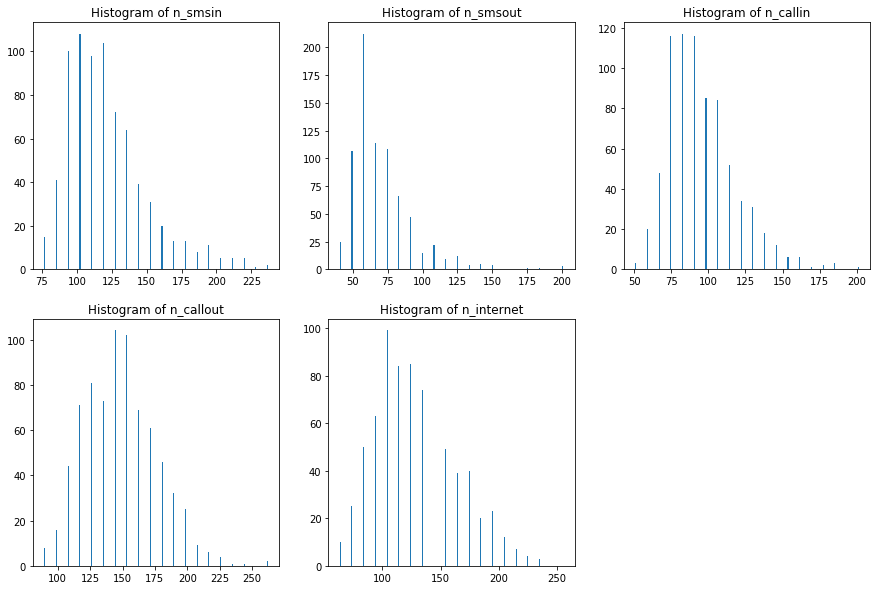

In [67]:
group9 = pred.filter(fn.col('prediction')==9)
visualize(group9,['n_smsin', 'n_smsout', 'n_callin', 'n_callout', 'n_internet'])